In [12]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from tqdm import tqdm

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros(len(Q[observation]), dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A

    return policy_fn

In [18]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.float32(0.0))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode in tqdm(range(1, num_episodes + 1)):
       # if i_episode % 100 == 0:
       #     print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
       # sys.stdout.flush()
            
        # generate an episode using behavior_policy
        state = env.reset()
        episode = []
        for t in range(100):
            action = np.random.choice(env.action_space.n, p=behavior_policy(state))
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        sa_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            W = np.prod(np.array([target_policy(x[0])[x[1]] / behavior_policy(x[0])[x[1]]
                         for x in episode[first_occurence_idx:]]))
            C[sa_pair] = C[sa_pair] + W
            if C[sa_pair] > 0:
                Q[state][action] += W / C[sa_pair] * (G - Q[state][action])
        
    return Q, target_policy

In [20]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

  2%|▏         | 11993/500000 [00:03<02:32, 3189.59it/s]


KeyboardInterrupt: 

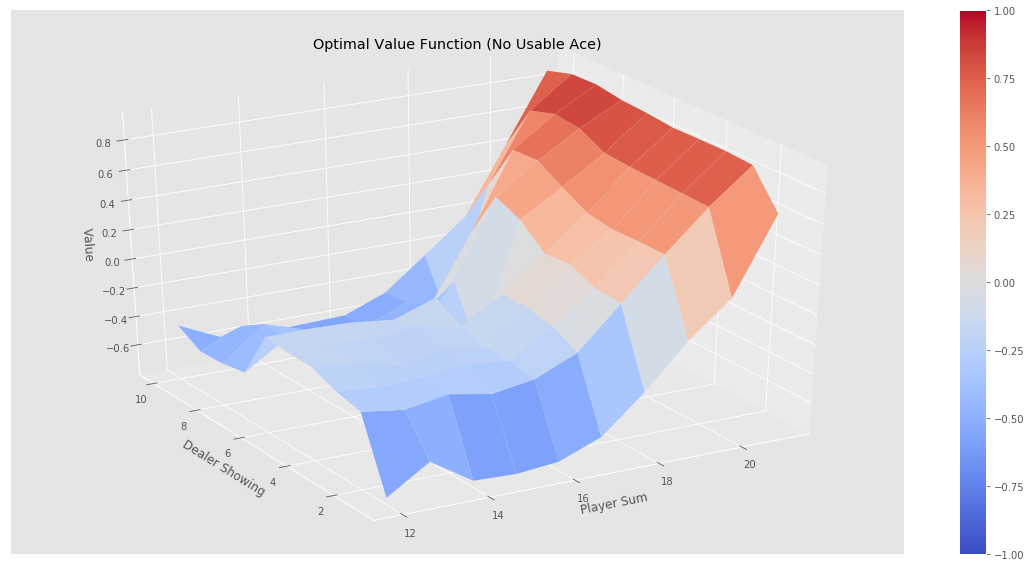

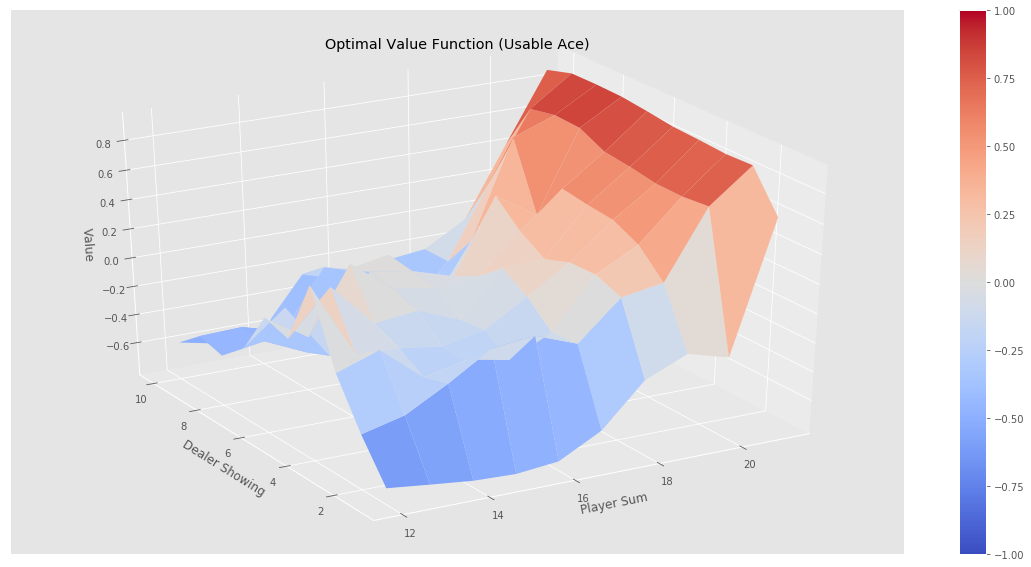

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")